## 1. Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Set random seeds for reproducibility
torch.manual_seed(10)
np.random.seed(10)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 2. Dataset Loading and Preprocessing

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.77MB/s]


Training samples: 60000
Test samples: 10000


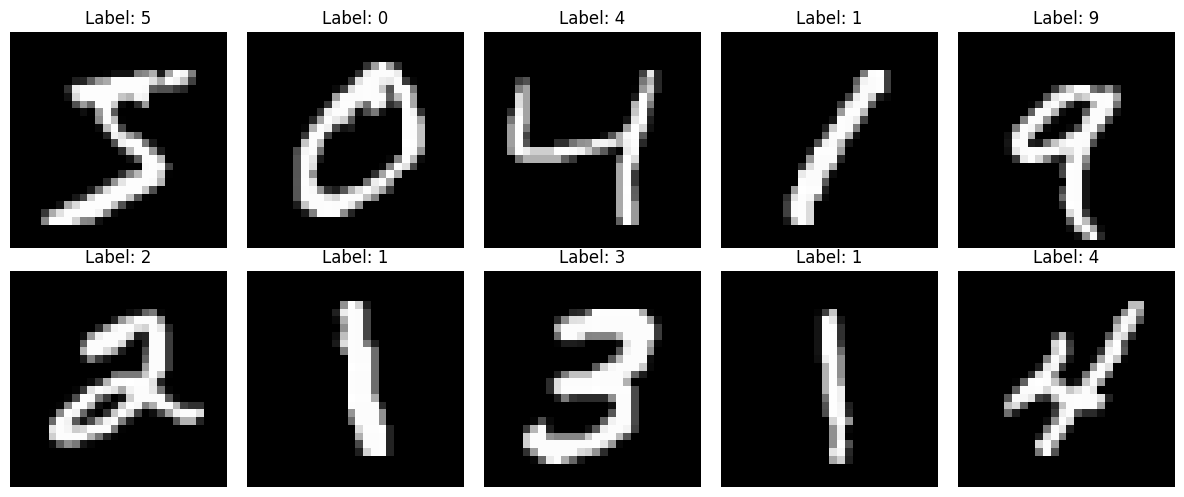

In [2]:
# Preprocessing: Convert to tensor and normalize to [0, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load MNIST dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')

# Visualize some samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## 3. VAE Model Implementation

In [3]:
class Encoder(nn.Module):
    """Encoder: Maps images to latent space (μ and log(σ²))"""
    def __init__(self, latent_dim=128):
        super(Encoder, self).__init__()

        # Convolutional layers
        # Input: 1 x 28 x 28
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)  # 32 x 14 x 14
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) # 64 x 7 x 7
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) # 128 x 4 x 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1) # 256 x 2 x 2

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Flatten dimension: 256 * 2 * 2 = 1024
        self.flatten_dim = 256 * 2 * 2

        # Linear layers for μ and log(σ²)
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

    def forward(self, x):
        # Convolutional layers with ReLU activation
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # Output μ and log(σ²)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

In [4]:
class Decoder(nn.Module):
    """Decoder: Maps latent vectors back to image space"""
    def __init__(self, latent_dim=128):
        super(Decoder, self).__init__()

        # Linear layer to expand latent vector
        self.fc = nn.Linear(latent_dim, 256 * 2 * 2)

        # Transpose convolutional layers (upsampling)
        # Input: 256 x 2 x 2
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1) # 128 x 4 x 4
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # 64 x 8 x 8
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)   # 32 x 16 x 16
        self.deconv4 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)    # 1 x 32 x 32

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(32)

    def forward(self, z):
        # Expand and reshape
        x = self.fc(z)
        x = x.view(x.size(0), 256, 2, 2)

        # Transpose convolutions with ReLU activation
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = F.relu(self.bn3(self.deconv3(x)))
        x = self.deconv4(x)

        # Crop to 28x28 (from 32x32) and apply sigmoid
        x = x[:, :, 2:30, 2:30]
        x = torch.sigmoid(x)

        return x

In [5]:
class VAE(nn.Module):
    """Complete VAE model combining Encoder and Decoder"""
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        """Reparameterization trick: z = μ + σ * ε, where ε ~ N(0,1)"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        # Encode
        mu, logvar = self.encoder(x)

        # Reparameterize
        z = self.reparameterize(mu, logvar)

        # Decode
        reconstruction = self.decoder(z)

        return reconstruction, mu, logvar

    def sample(self, num_samples):
        """Generate samples from random z vectors"""
        with torch.no_grad():
            z = torch.randn(num_samples, self.latent_dim).to(device)
            samples = self.decoder(z)
        return samples

## 4. Loss Function

In [6]:
def vae_loss(reconstruction, x, mu, logvar, reconstruction_loss='BCE'):
    """
    VAE loss = Reconstruction loss + KL divergence

    Args:
        reconstruction: Reconstructed images
        x: Original images
        mu: Mean of latent distribution
        logvar: Log variance of latent distribution
        reconstruction_loss: 'BCE' or 'MSE'
    """
    # Reconstruction loss
    if reconstruction_loss == 'BCE':
        recon_loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')
    else:  # MSE
        recon_loss = F.mse_loss(reconstruction, x, reduction='sum')

    # KL divergence: -0.5 * sum(1 + log(σ²) - μ² - σ²)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    total_loss = recon_loss + kl_loss

    return total_loss, recon_loss, kl_loss

## 5. Training Function

In [7]:
def train_vae(model, train_loader, optimizer, epoch):
    """Train the VAE for one epoch"""
    model.train()
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch}')

    for batch_idx, (data, _) in enumerate(progress_bar):
        data = data.to(device)

        # Forward pass
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)

        # Compute loss
        loss, recon_loss, kl_loss = vae_loss(reconstruction, data, mu, logvar, reconstruction_loss='BCE')

        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumulate losses
        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': loss.item() / len(data),
            'recon': recon_loss.item() / len(data),
            'kl': kl_loss.item() / len(data)
        })

    # Average losses
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = train_recon_loss / len(train_loader.dataset)
    avg_kl_loss = train_kl_loss / len(train_loader.dataset)

    return avg_loss, avg_recon_loss, avg_kl_loss

In [8]:
def test_vae(model, test_loader):
    """Evaluate the VAE on test set"""
    model.eval()
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            loss, recon_loss, kl_loss = vae_loss(reconstruction, data, mu, logvar, reconstruction_loss='BCE')

            test_loss += loss.item()
            test_recon_loss += recon_loss.item()
            test_kl_loss += kl_loss.item()

    # Average losses
    avg_loss = test_loss / len(test_loader.dataset)
    avg_recon_loss = test_recon_loss / len(test_loader.dataset)
    avg_kl_loss = test_kl_loss / len(test_loader.dataset)

    return avg_loss, avg_recon_loss, avg_kl_loss

## 6. Visualization Functions

In [9]:
def visualize_reconstruction(model, test_loader, num_images=10):
    """Visualize original vs reconstructed images"""
    model.eval()

    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data[:num_images].to(device)
        reconstruction, _, _ = model(data)

        # Move to CPU for visualization
        data = data.cpu()
        reconstruction = reconstruction.cpu()

        # Plot
        fig, axes = plt.subplots(2, num_images, figsize=(15, 3))
        for i in range(num_images):
            # Original
            axes[0, i].imshow(data[i].squeeze(), cmap='gray')
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_title('Original', fontsize=10)

            # Reconstruction
            axes[1, i].imshow(reconstruction[i].squeeze(), cmap='gray')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_title('Reconstructed', fontsize=10)

        plt.tight_layout()
        plt.show()

def visualize_latent_space(model, test_loader, epoch):
    """Visualize latent space (2D projection using first 2 dimensions)"""
    model.eval()

    latent_vectors = []
    labels_list = []

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            mu, _ = model.encoder(data)
            latent_vectors.append(mu.cpu().numpy())
            labels_list.append(labels.numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels_list = np.concatenate(labels_list, axis=0)

    # Plot first 2 dimensions
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1],
                         c=labels_list, cmap='tab10', alpha=0.5, s=5)
    plt.colorbar(scatter)
    plt.title(f'Latent Space Visualization (Epoch {epoch})')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.grid(True, alpha=0.3)
    plt.show()

def generate_samples(model, num_samples=25):
    """Generate new images from random latent vectors"""
    samples = model.sample(num_samples)
    samples = samples.cpu()

    # Plot generated images
    grid_size = int(np.sqrt(num_samples))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].squeeze(), cmap='gray')
        ax.axis('off')

    plt.suptitle('Generated Samples', fontsize=16)
    plt.tight_layout()
    plt.show()

def interpolate_latent(model, test_loader, num_steps=10):
    """Interpolate between two latent vectors"""
    model.eval()

    with torch.no_grad():
        # Get two random images
        data, _ = next(iter(test_loader))
        img1, img2 = data[0:1].to(device), data[1:2].to(device)

        # Encode to latent space
        mu1, _ = model.encoder(img1)
        mu2, _ = model.encoder(img2)

        # Interpolate
        alphas = np.linspace(0, 1, num_steps)
        interpolated_images = []

        for alpha in alphas:
            z = (1 - alpha) * mu1 + alpha * mu2
            img = model.decoder(z)
            interpolated_images.append(img.cpu())

        # Plot interpolation
        fig, axes = plt.subplots(1, num_steps, figsize=(15, 2))
        for i, ax in enumerate(axes):
            ax.imshow(interpolated_images[i].squeeze(), cmap='gray')
            ax.axis('off')
            ax.set_title(f'α={alphas[i]:.1f}', fontsize=8)

        plt.suptitle('Latent Space Interpolation', fontsize=14)
        plt.tight_layout()
        plt.show()

## 7. Training with Latent Dimension = 128

In [10]:
# Initialize model with latent_dim=128
latent_dim_1 = 128
model_128 = VAE(latent_dim=latent_dim_1).to(device)

# Optimizer
optimizer = optim.Adam(model_128.parameters(), lr=1e-3)

# Training parameters
num_epochs = 50

# Track losses
train_losses_128 = []
test_losses_128 = []

print(f"\nTraining VAE with latent_dim={latent_dim_1}")
print("="*50)


Training VAE with latent_dim=128


Epoch 1: 100%|██████████| 469/469 [00:13<00:00, 33.81it/s, loss=113, recon=91, kl=22.4]


Epoch 1/50 - Train Loss: 144.1206 - Test Loss: 114.1103

--- Visualizations at Epoch 1 ---


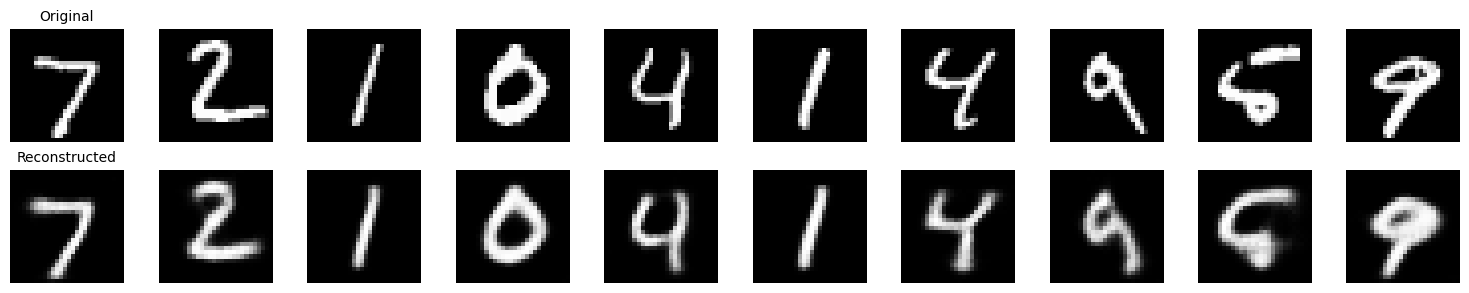

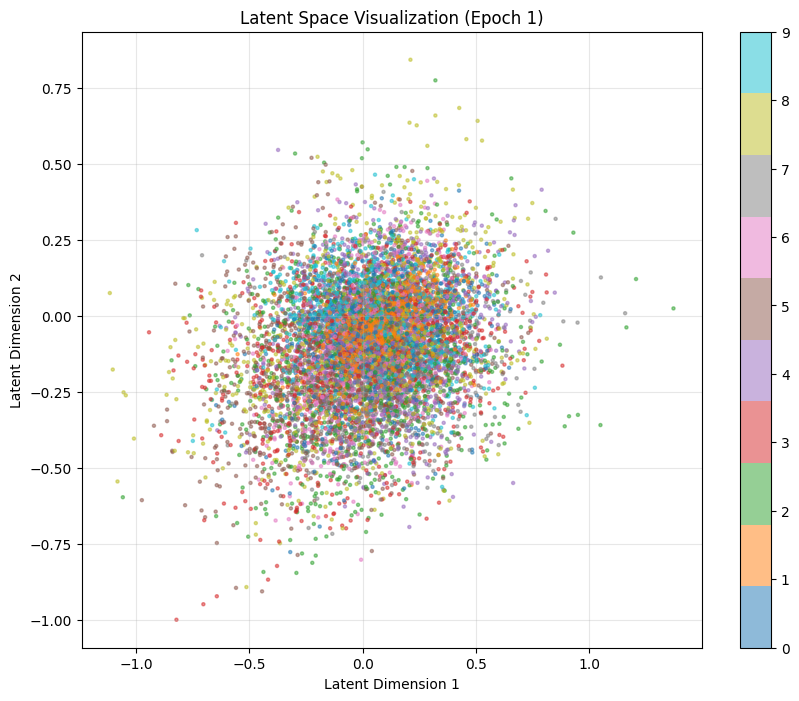

Epoch 2: 100%|██████████| 469/469 [00:14<00:00, 32.11it/s, loss=102, recon=80.2, kl=22]


Epoch 2/50 - Train Loss: 110.5822 - Test Loss: 106.7827


Epoch 3: 100%|██████████| 469/469 [00:15<00:00, 31.00it/s, loss=105, recon=82.8, kl=22.5]


Epoch 3/50 - Train Loss: 105.5657 - Test Loss: 105.0556


Epoch 4: 100%|██████████| 469/469 [00:14<00:00, 33.17it/s, loss=104, recon=79.7, kl=23.8]


Epoch 4/50 - Train Loss: 103.2668 - Test Loss: 101.3690


Epoch 5: 100%|██████████| 469/469 [00:13<00:00, 33.68it/s, loss=102, recon=78.6, kl=23.7]


Epoch 5/50 - Train Loss: 101.7581 - Test Loss: 100.8728


Epoch 6: 100%|██████████| 469/469 [00:13<00:00, 34.37it/s, loss=101, recon=77.4, kl=23.7]


Epoch 6/50 - Train Loss: 100.7276 - Test Loss: 99.8579


Epoch 7: 100%|██████████| 469/469 [00:14<00:00, 33.09it/s, loss=101, recon=77.3, kl=23.7]


Epoch 7/50 - Train Loss: 99.9929 - Test Loss: 99.6849


Epoch 8: 100%|██████████| 469/469 [00:13<00:00, 33.56it/s, loss=97.5, recon=73.2, kl=24.3]


Epoch 8/50 - Train Loss: 99.3744 - Test Loss: 98.6528


Epoch 9: 100%|██████████| 469/469 [00:13<00:00, 33.61it/s, loss=95.9, recon=73.3, kl=22.6]


Epoch 9/50 - Train Loss: 98.8237 - Test Loss: 98.4971


Epoch 10: 100%|██████████| 469/469 [00:13<00:00, 33.81it/s, loss=100, recon=76.5, kl=24]


Epoch 10/50 - Train Loss: 98.4137 - Test Loss: 97.6623

--- Visualizations at Epoch 10 ---


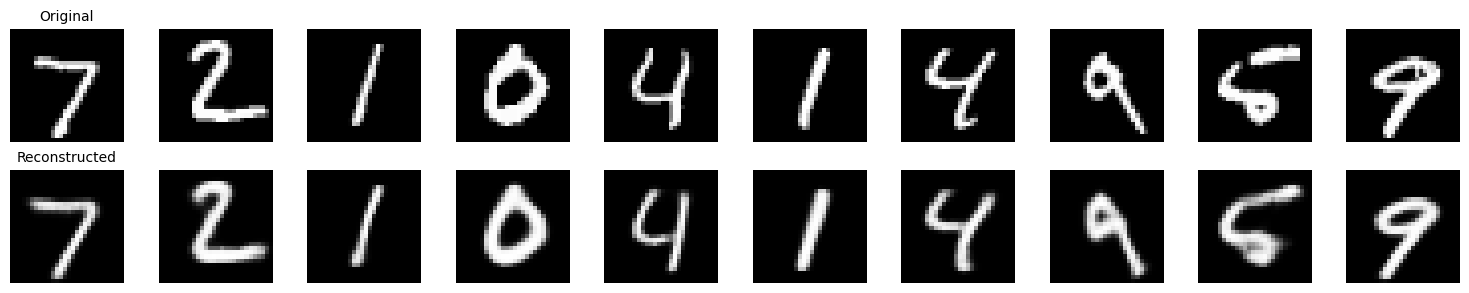

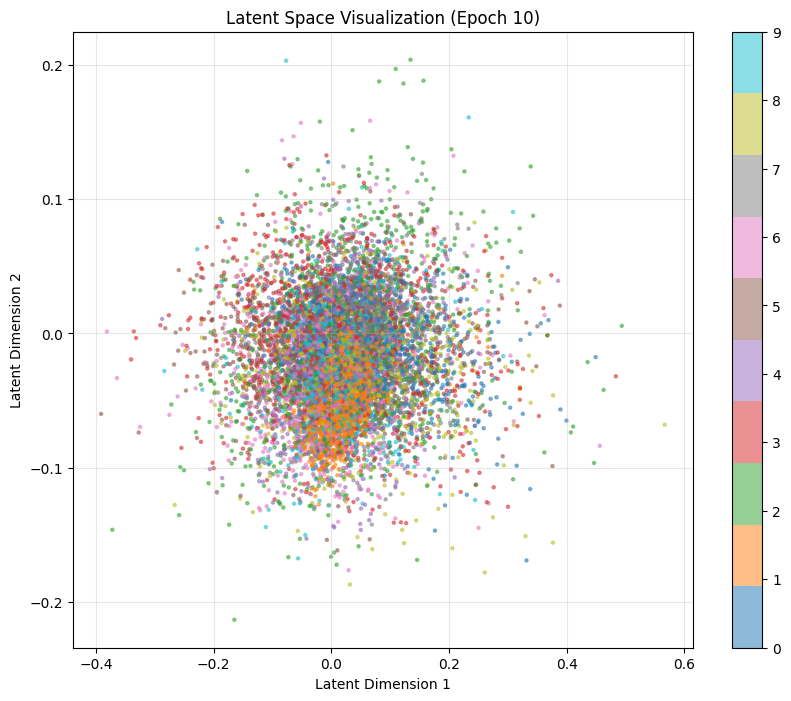

Epoch 11: 100%|██████████| 469/469 [00:15<00:00, 31.17it/s, loss=101, recon=76.8, kl=24.3]


Epoch 11/50 - Train Loss: 98.0372 - Test Loss: 97.2589


Epoch 12: 100%|██████████| 469/469 [00:14<00:00, 31.92it/s, loss=98.3, recon=75, kl=23.4]


Epoch 12/50 - Train Loss: 97.6304 - Test Loss: 97.0391


Epoch 13: 100%|██████████| 469/469 [00:14<00:00, 31.75it/s, loss=97.4, recon=73.7, kl=23.7]


Epoch 13/50 - Train Loss: 97.3313 - Test Loss: 96.8920


Epoch 14: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s, loss=100, recon=77, kl=23.4]


Epoch 14/50 - Train Loss: 97.0357 - Test Loss: 97.0727


Epoch 15: 100%|██████████| 469/469 [00:14<00:00, 31.42it/s, loss=97.3, recon=73.7, kl=23.6]


Epoch 15/50 - Train Loss: 96.7652 - Test Loss: 96.5187


Epoch 16: 100%|██████████| 469/469 [00:15<00:00, 31.14it/s, loss=102, recon=78.5, kl=23.9]


Epoch 16/50 - Train Loss: 96.5397 - Test Loss: 96.4163


Epoch 17: 100%|██████████| 469/469 [00:14<00:00, 31.94it/s, loss=97, recon=73.6, kl=23.4]


Epoch 17/50 - Train Loss: 96.3569 - Test Loss: 96.2802


Epoch 18: 100%|██████████| 469/469 [00:14<00:00, 31.80it/s, loss=97.6, recon=74.9, kl=22.8]


Epoch 18/50 - Train Loss: 96.1830 - Test Loss: 95.9686


Epoch 19: 100%|██████████| 469/469 [00:14<00:00, 31.36it/s, loss=97.2, recon=73.8, kl=23.4]


Epoch 19/50 - Train Loss: 95.9343 - Test Loss: 95.6295


Epoch 20: 100%|██████████| 469/469 [00:14<00:00, 32.05it/s, loss=91.1, recon=67.8, kl=23.2]


Epoch 20/50 - Train Loss: 95.8441 - Test Loss: 95.6183

--- Visualizations at Epoch 20 ---


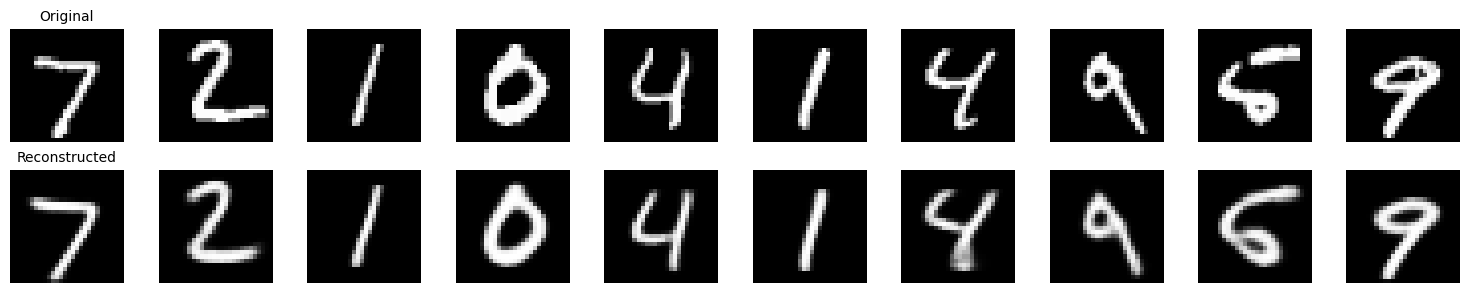

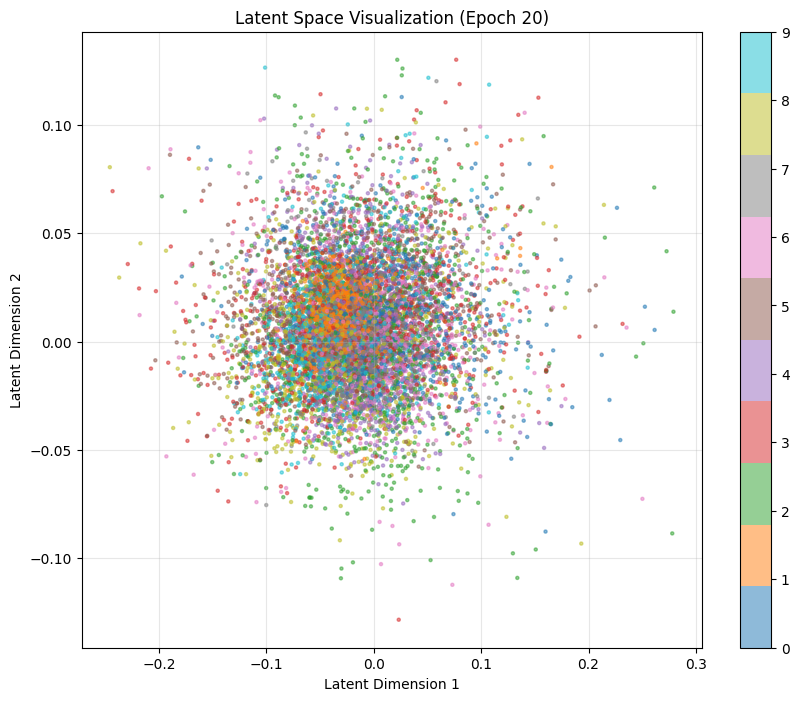

Epoch 21: 100%|██████████| 469/469 [00:15<00:00, 30.57it/s, loss=97.4, recon=74.7, kl=22.7]


Epoch 21/50 - Train Loss: 95.6817 - Test Loss: 96.3352


Epoch 22: 100%|██████████| 469/469 [00:15<00:00, 29.45it/s, loss=94.9, recon=71.8, kl=23.1]


Epoch 22/50 - Train Loss: 95.4771 - Test Loss: 95.4321


Epoch 23: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s, loss=95.4, recon=72.1, kl=23.3]


Epoch 23/50 - Train Loss: 95.3412 - Test Loss: 95.2906


Epoch 24: 100%|██████████| 469/469 [00:15<00:00, 29.42it/s, loss=97.8, recon=74, kl=23.8]


Epoch 24/50 - Train Loss: 95.2506 - Test Loss: 95.3052


Epoch 25: 100%|██████████| 469/469 [00:15<00:00, 30.23it/s, loss=98, recon=74.5, kl=23.5]


Epoch 25/50 - Train Loss: 95.1117 - Test Loss: 94.7778


Epoch 26: 100%|██████████| 469/469 [00:15<00:00, 30.06it/s, loss=97, recon=73.1, kl=23.9]


Epoch 26/50 - Train Loss: 94.9017 - Test Loss: 95.2401


Epoch 27: 100%|██████████| 469/469 [00:15<00:00, 29.97it/s, loss=99, recon=75.2, kl=23.9]


Epoch 27/50 - Train Loss: 94.8841 - Test Loss: 94.7943


Epoch 28: 100%|██████████| 469/469 [00:15<00:00, 31.26it/s, loss=96.4, recon=73.5, kl=22.9]


Epoch 28/50 - Train Loss: 94.7233 - Test Loss: 94.8830


Epoch 29: 100%|██████████| 469/469 [00:15<00:00, 30.19it/s, loss=95.3, recon=71.8, kl=23.5]


Epoch 29/50 - Train Loss: 94.6320 - Test Loss: 94.6353


Epoch 30: 100%|██████████| 469/469 [00:15<00:00, 30.73it/s, loss=96.1, recon=71.3, kl=24.7]


Epoch 30/50 - Train Loss: 94.5439 - Test Loss: 94.5997

--- Visualizations at Epoch 30 ---


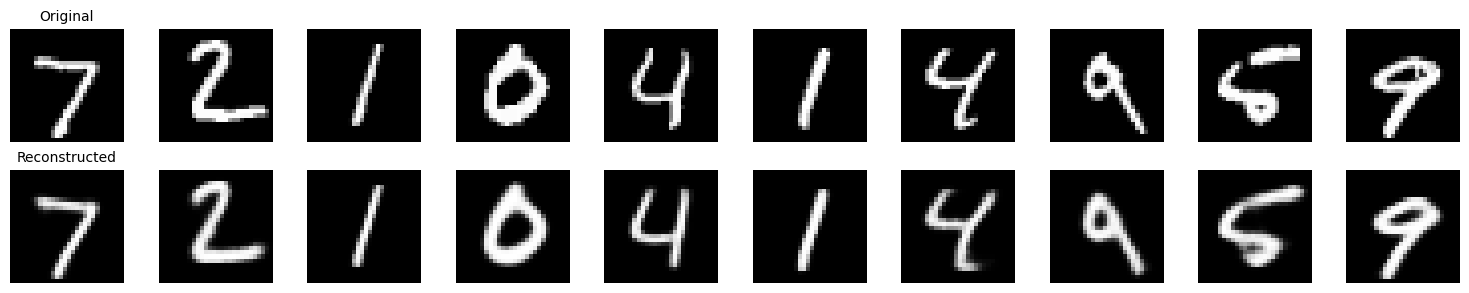

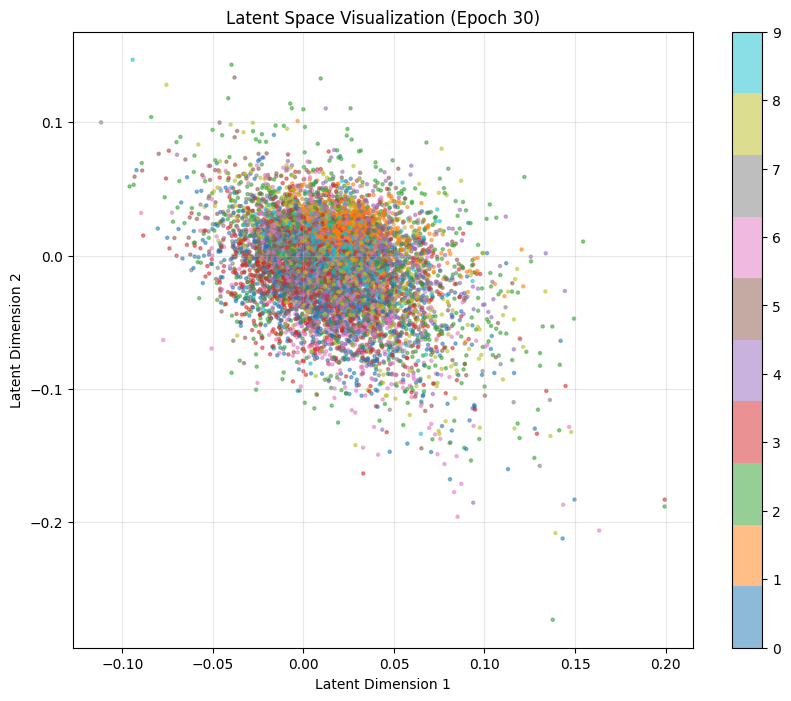

Epoch 31: 100%|██████████| 469/469 [00:15<00:00, 30.45it/s, loss=94.7, recon=72.7, kl=22]


Epoch 31/50 - Train Loss: 94.4642 - Test Loss: 95.1607


Epoch 32: 100%|██████████| 469/469 [00:15<00:00, 29.42it/s, loss=93, recon=71.2, kl=21.7]


Epoch 32/50 - Train Loss: 94.3531 - Test Loss: 94.6997


Epoch 33: 100%|██████████| 469/469 [00:15<00:00, 30.44it/s, loss=91.5, recon=69.4, kl=22.1]


Epoch 33/50 - Train Loss: 94.3113 - Test Loss: 94.4949


Epoch 34: 100%|██████████| 469/469 [00:15<00:00, 31.06it/s, loss=93.5, recon=70.9, kl=22.6]


Epoch 34/50 - Train Loss: 94.2063 - Test Loss: 94.4071


Epoch 35: 100%|██████████| 469/469 [00:15<00:00, 30.69it/s, loss=95.7, recon=72.9, kl=22.8]


Epoch 35/50 - Train Loss: 94.0776 - Test Loss: 94.5056


Epoch 36: 100%|██████████| 469/469 [00:15<00:00, 30.55it/s, loss=95.4, recon=72.3, kl=23.1]


Epoch 36/50 - Train Loss: 93.9994 - Test Loss: 94.3667


Epoch 37: 100%|██████████| 469/469 [00:15<00:00, 30.39it/s, loss=97.1, recon=73.9, kl=23.2]


Epoch 37/50 - Train Loss: 94.0090 - Test Loss: 94.2148


Epoch 38: 100%|██████████| 469/469 [00:15<00:00, 30.60it/s, loss=96.4, recon=72.4, kl=24]


Epoch 38/50 - Train Loss: 93.8675 - Test Loss: 94.1851


Epoch 39: 100%|██████████| 469/469 [00:15<00:00, 30.88it/s, loss=94.3, recon=71.8, kl=22.5]


Epoch 39/50 - Train Loss: 93.8368 - Test Loss: 94.0706


Epoch 40: 100%|██████████| 469/469 [00:15<00:00, 29.81it/s, loss=94.8, recon=71, kl=23.8]


Epoch 40/50 - Train Loss: 93.7506 - Test Loss: 94.2449

--- Visualizations at Epoch 40 ---


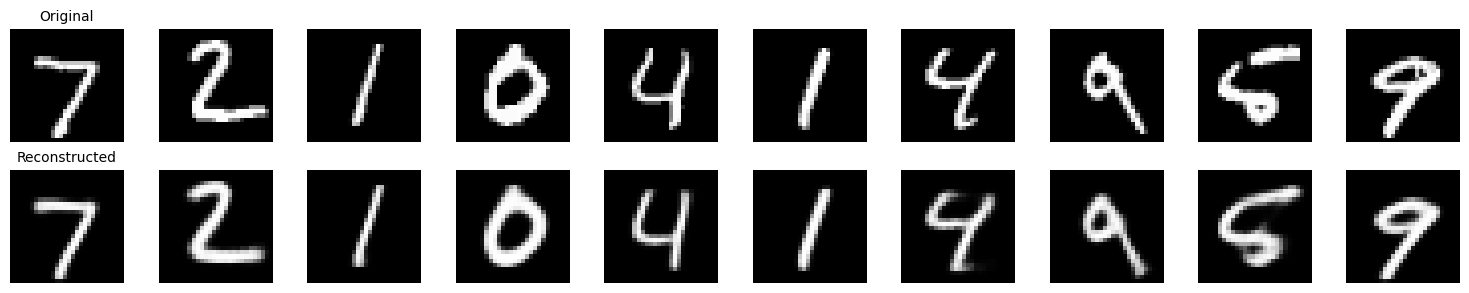

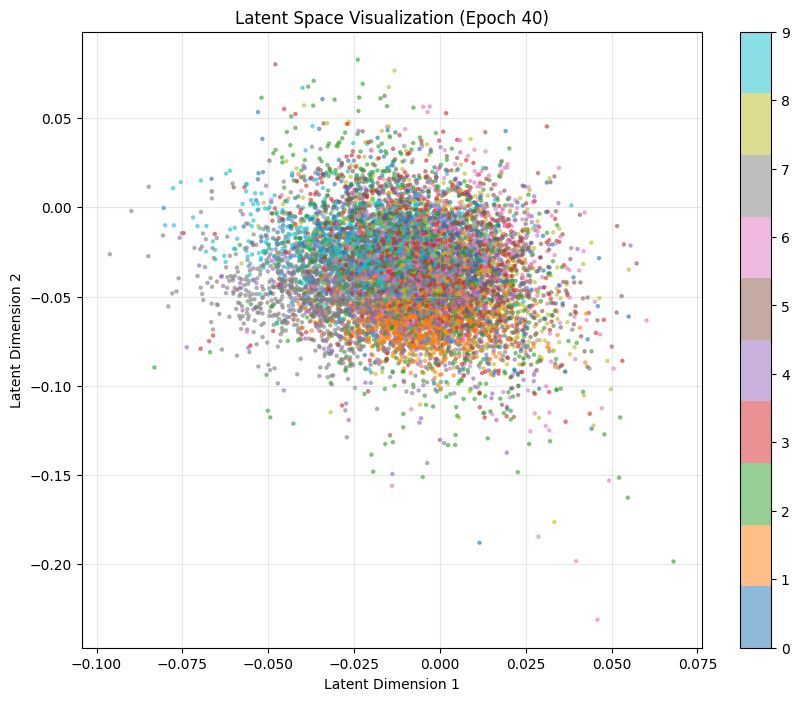

Epoch 41: 100%|██████████| 469/469 [00:15<00:00, 30.21it/s, loss=94.3, recon=70.9, kl=23.4]


Epoch 41/50 - Train Loss: 93.6613 - Test Loss: 94.0325


Epoch 42: 100%|██████████| 469/469 [00:15<00:00, 30.49it/s, loss=95.2, recon=72.8, kl=22.4]


Epoch 42/50 - Train Loss: 93.6202 - Test Loss: 94.0351


Epoch 43: 100%|██████████| 469/469 [00:15<00:00, 29.62it/s, loss=94.3, recon=71.1, kl=23.1]


Epoch 43/50 - Train Loss: 93.5389 - Test Loss: 94.2788


Epoch 44: 100%|██████████| 469/469 [00:15<00:00, 30.03it/s, loss=92, recon=70.3, kl=21.6]


Epoch 44/50 - Train Loss: 93.5333 - Test Loss: 94.0716


Epoch 45: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s, loss=90.6, recon=67.5, kl=23.2]


Epoch 45/50 - Train Loss: 93.4482 - Test Loss: 93.9091


Epoch 46: 100%|██████████| 469/469 [00:15<00:00, 30.25it/s, loss=94.6, recon=71, kl=23.5]


Epoch 46/50 - Train Loss: 93.3582 - Test Loss: 94.0615


Epoch 47: 100%|██████████| 469/469 [00:15<00:00, 29.91it/s, loss=95.3, recon=71.8, kl=23.5]


Epoch 47/50 - Train Loss: 93.3386 - Test Loss: 93.9723


Epoch 48: 100%|██████████| 469/469 [00:15<00:00, 29.76it/s, loss=97.5, recon=73.8, kl=23.7]


Epoch 48/50 - Train Loss: 93.2753 - Test Loss: 93.7879


Epoch 49: 100%|██████████| 469/469 [00:15<00:00, 30.58it/s, loss=93, recon=69.9, kl=23.1]


Epoch 49/50 - Train Loss: 93.2621 - Test Loss: 93.7931


Epoch 50: 100%|██████████| 469/469 [00:15<00:00, 29.91it/s, loss=97.1, recon=73.8, kl=23.2]


Epoch 50/50 - Train Loss: 93.1460 - Test Loss: 93.7159

--- Visualizations at Epoch 50 ---


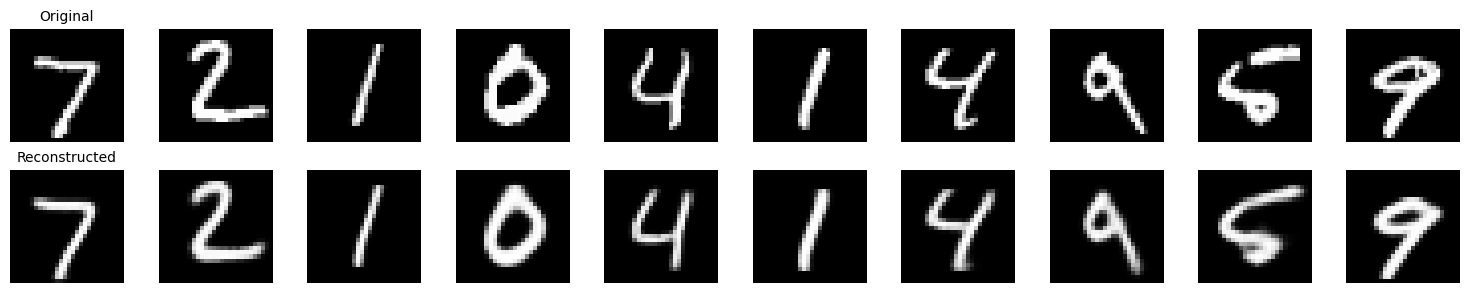

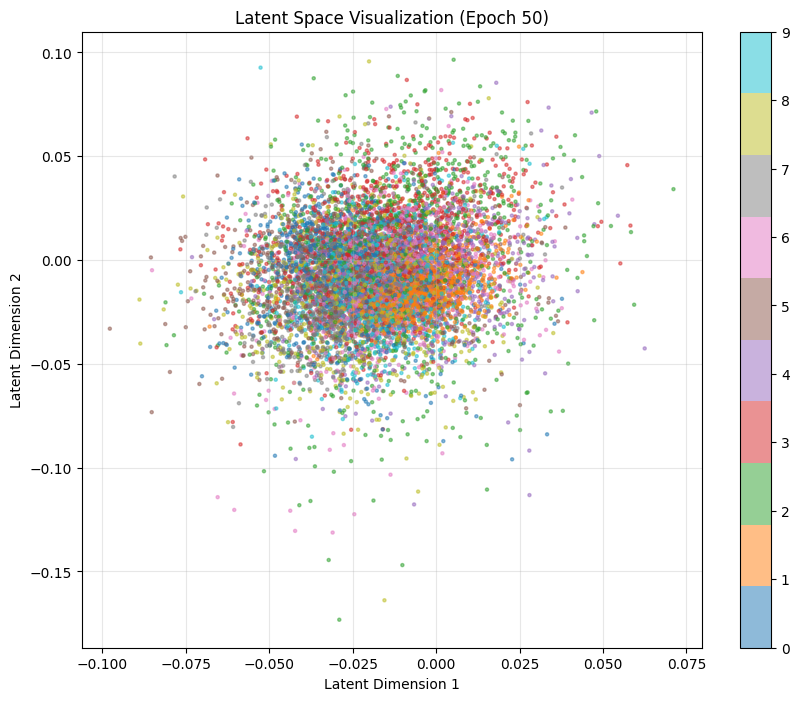

In [11]:
# Training loop
for epoch in range(1, num_epochs + 1):
    # Train
    train_loss, train_recon, train_kl = train_vae(model_128, train_loader, optimizer, epoch)

    # Test
    test_loss, test_recon, test_kl = test_vae(model_128, test_loader)

    # Store losses
    train_losses_128.append(train_loss)
    test_losses_128.append(test_loss)

    # Print epoch summary
    print(f'Epoch {epoch}/{num_epochs} - '
          f'Train Loss: {train_loss:.4f} - '
          f'Test Loss: {test_loss:.4f}')

    # Visualize every 10 epochs
    if epoch % 10 == 0 or epoch == 1:
        print(f"\n--- Visualizations at Epoch {epoch} ---")
        visualize_reconstruction(model_128, test_loader)
        visualize_latent_space(model_128, test_loader, epoch)
        print()

## 8. Training Loss Visualization (latent_dim=128)

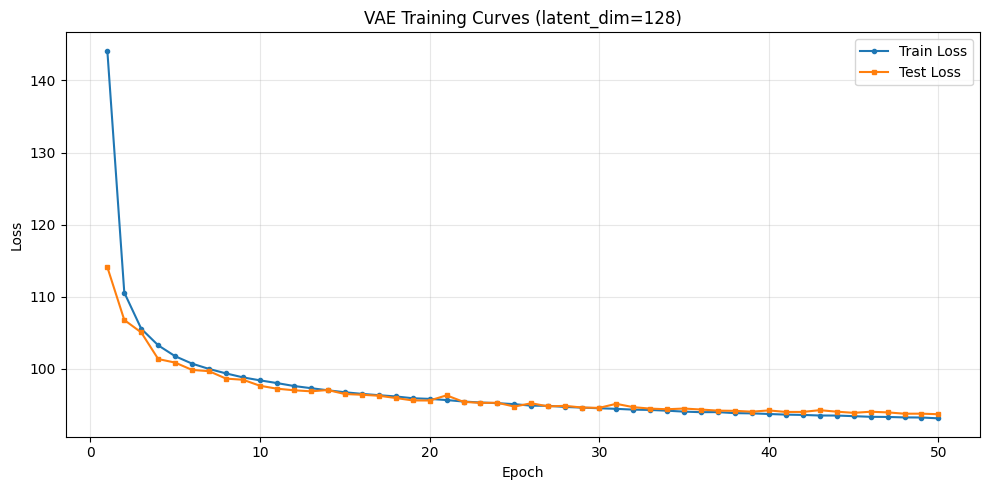

In [12]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses_128, label='Train Loss', marker='o', markersize=3)
plt.plot(range(1, num_epochs + 1), test_losses_128, label='Test Loss', marker='s', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Curves (latent_dim=128)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Generation and Visualization (latent_dim=128)

Generating random samples from latent space (latent_dim=128)...


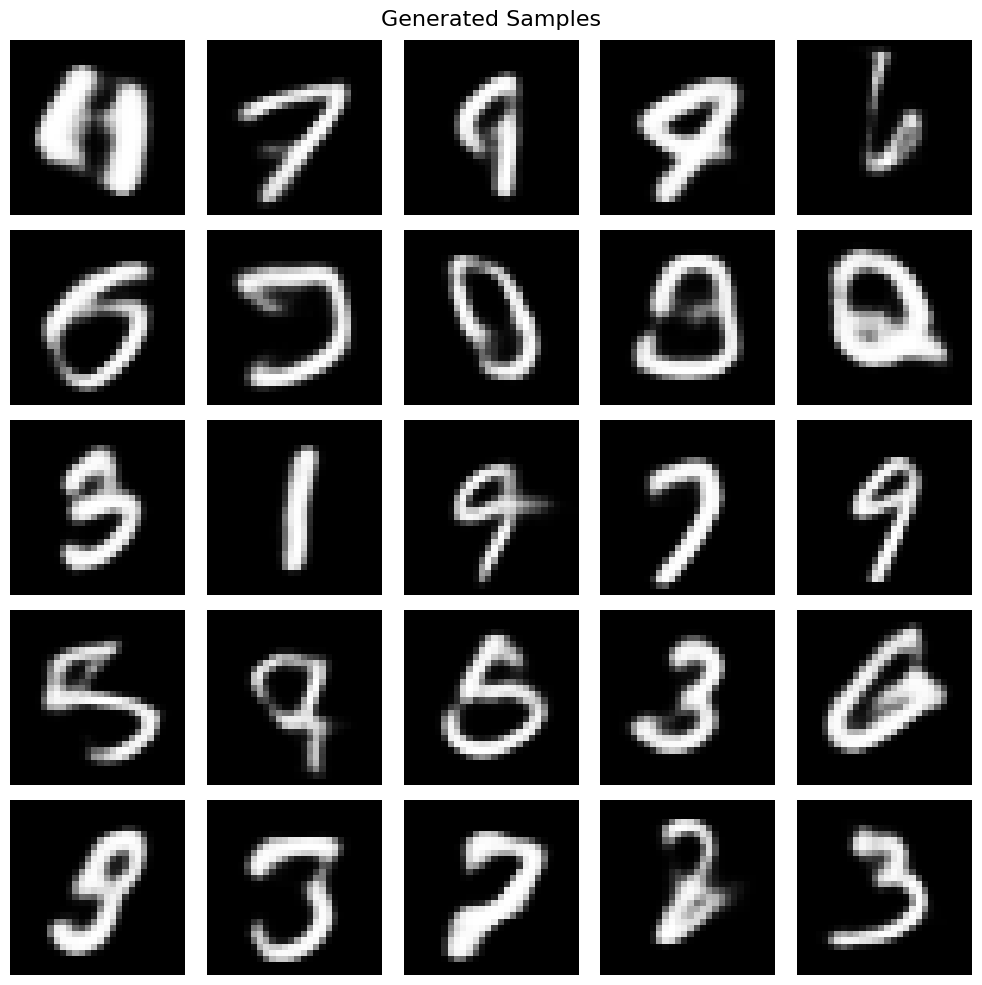

In [13]:
# Generate random samples
print("Generating random samples from latent space (latent_dim=128)...")
generate_samples(model_128, num_samples=25)


Interpolating between two latent vectors (latent_dim=128)...


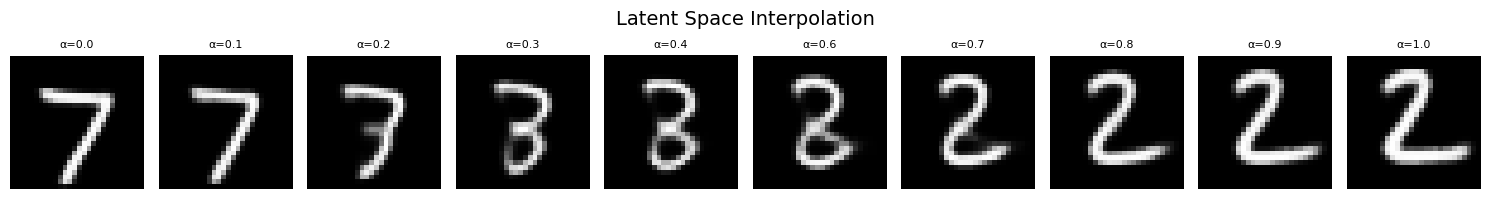

In [14]:
# Interpolate between two images
print("\nInterpolating between two latent vectors (latent_dim=128)...")
interpolate_latent(model_128, test_loader, num_steps=10)


Final Reconstruction Quality (latent_dim=128):


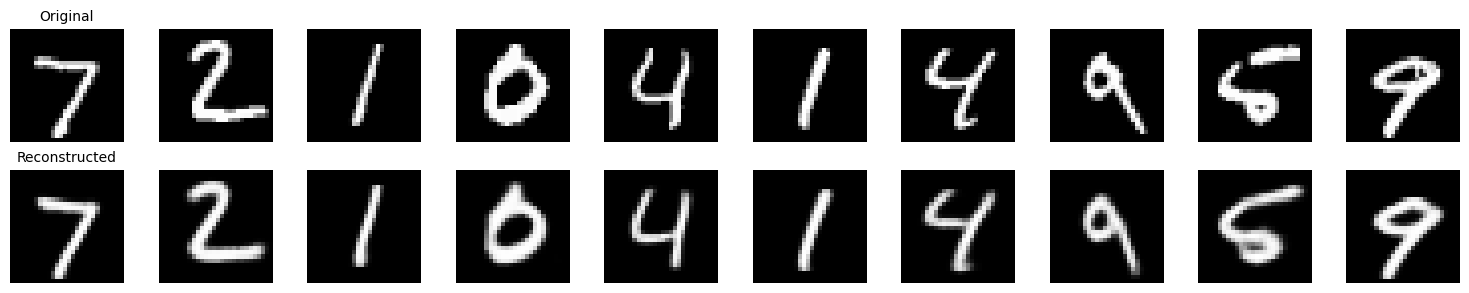

In [15]:
# Final reconstruction quality
print("\nFinal Reconstruction Quality (latent_dim=128):")
visualize_reconstruction(model_128, test_loader, num_images=10)

## 10. Training with Latent Dimension = 256

In [16]:
# Initialize model with latent_dim=256
latent_dim_2 = 256
model_256 = VAE(latent_dim=latent_dim_2).to(device)

# Optimizer
optimizer_256 = optim.Adam(model_256.parameters(), lr=1e-3)

# Track losses
train_losses_256 = []
test_losses_256 = []

print(f"\nTraining VAE with latent_dim={latent_dim_2}")
print("="*50)


Training VAE with latent_dim=256


Epoch 1: 100%|██████████| 469/469 [00:12<00:00, 36.76it/s, loss=122, recon=99.1, kl=22.9]


Epoch 1/50 - Train Loss: 159.4693 - Test Loss: 125.4796

--- Visualizations at Epoch 1 ---


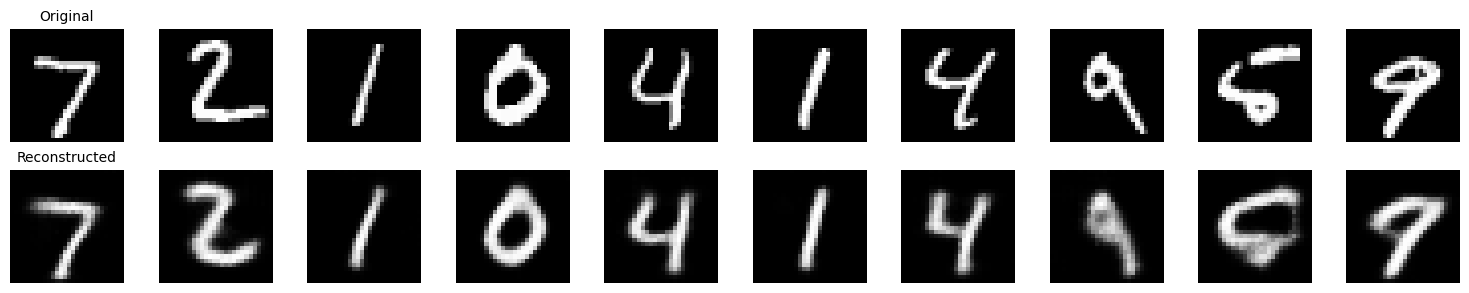

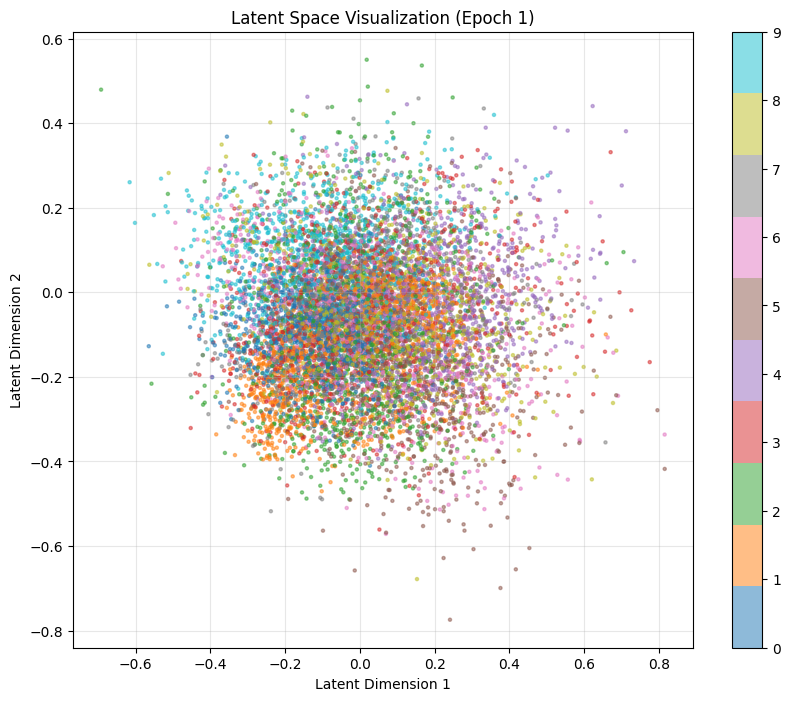

Epoch 2: 100%|██████████| 469/469 [00:14<00:00, 32.08it/s, loss=108, recon=85.9, kl=22]


Epoch 2/50 - Train Loss: 117.0209 - Test Loss: 114.3329


Epoch 3: 100%|██████████| 469/469 [00:14<00:00, 32.16it/s, loss=110, recon=86.2, kl=23.6]


Epoch 3/50 - Train Loss: 109.4738 - Test Loss: 107.9893


Epoch 4: 100%|██████████| 469/469 [00:14<00:00, 32.53it/s, loss=102, recon=79.2, kl=23.1]


Epoch 4/50 - Train Loss: 106.0322 - Test Loss: 103.6471


Epoch 5: 100%|██████████| 469/469 [00:14<00:00, 32.69it/s, loss=106, recon=82.8, kl=23]


Epoch 5/50 - Train Loss: 103.6254 - Test Loss: 101.9694


Epoch 6: 100%|██████████| 469/469 [00:13<00:00, 33.53it/s, loss=96.5, recon=75.5, kl=21]


Epoch 6/50 - Train Loss: 102.2715 - Test Loss: 100.8063


Epoch 7: 100%|██████████| 469/469 [00:13<00:00, 33.81it/s, loss=99.9, recon=75.8, kl=24.1]


Epoch 7/50 - Train Loss: 101.1417 - Test Loss: 100.1676


Epoch 8: 100%|██████████| 469/469 [00:13<00:00, 33.52it/s, loss=100, recon=77.2, kl=23.1]


Epoch 8/50 - Train Loss: 100.4572 - Test Loss: 99.4209


Epoch 9: 100%|██████████| 469/469 [00:14<00:00, 33.41it/s, loss=99.8, recon=77, kl=22.8]


Epoch 9/50 - Train Loss: 99.7330 - Test Loss: 99.4630


Epoch 10: 100%|██████████| 469/469 [00:14<00:00, 33.44it/s, loss=102, recon=80.1, kl=22.1]


Epoch 10/50 - Train Loss: 99.0754 - Test Loss: 98.5668

--- Visualizations at Epoch 10 ---


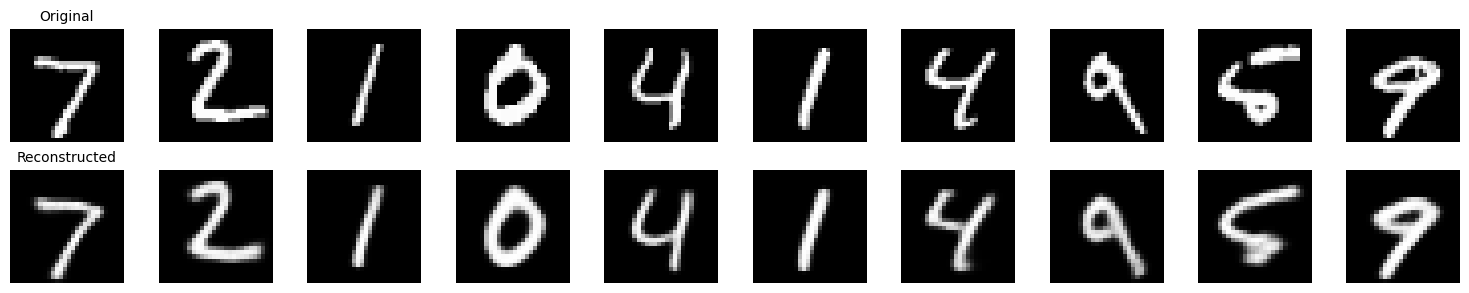

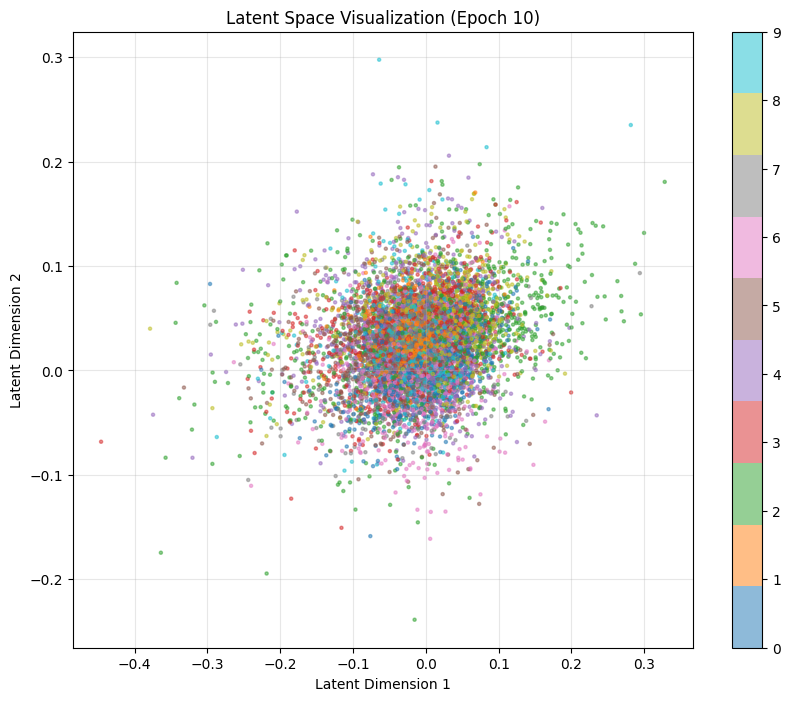

Epoch 11: 100%|██████████| 469/469 [00:14<00:00, 31.48it/s, loss=99.4, recon=76.1, kl=23.3]


Epoch 11/50 - Train Loss: 98.7644 - Test Loss: 98.2459


Epoch 12: 100%|██████████| 469/469 [00:14<00:00, 32.01it/s, loss=95, recon=72.5, kl=22.5]


Epoch 12/50 - Train Loss: 98.3160 - Test Loss: 98.1848


Epoch 13: 100%|██████████| 469/469 [00:14<00:00, 32.25it/s, loss=96.2, recon=72.7, kl=23.4]


Epoch 13/50 - Train Loss: 97.9463 - Test Loss: 97.7853


Epoch 14: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s, loss=99.6, recon=76.5, kl=23.2]


Epoch 14/50 - Train Loss: 97.6044 - Test Loss: 96.9232


Epoch 15: 100%|██████████| 469/469 [00:14<00:00, 31.29it/s, loss=95.1, recon=72.5, kl=22.6]


Epoch 15/50 - Train Loss: 97.3608 - Test Loss: 96.8572


Epoch 16: 100%|██████████| 469/469 [00:14<00:00, 32.19it/s, loss=99.4, recon=76.1, kl=23.3]


Epoch 16/50 - Train Loss: 97.0657 - Test Loss: 96.7855


Epoch 17: 100%|██████████| 469/469 [00:14<00:00, 32.52it/s, loss=99, recon=75, kl=23.9]


Epoch 17/50 - Train Loss: 96.9057 - Test Loss: 96.7378


Epoch 18: 100%|██████████| 469/469 [00:14<00:00, 31.86it/s, loss=97.9, recon=74.5, kl=23.4]


Epoch 18/50 - Train Loss: 96.5648 - Test Loss: 96.2587


Epoch 19: 100%|██████████| 469/469 [00:14<00:00, 31.33it/s, loss=96.5, recon=73.5, kl=23]


Epoch 19/50 - Train Loss: 96.3904 - Test Loss: 96.1951


Epoch 20: 100%|██████████| 469/469 [00:14<00:00, 32.07it/s, loss=92.7, recon=70.2, kl=22.5]


Epoch 20/50 - Train Loss: 96.1340 - Test Loss: 96.3062

--- Visualizations at Epoch 20 ---


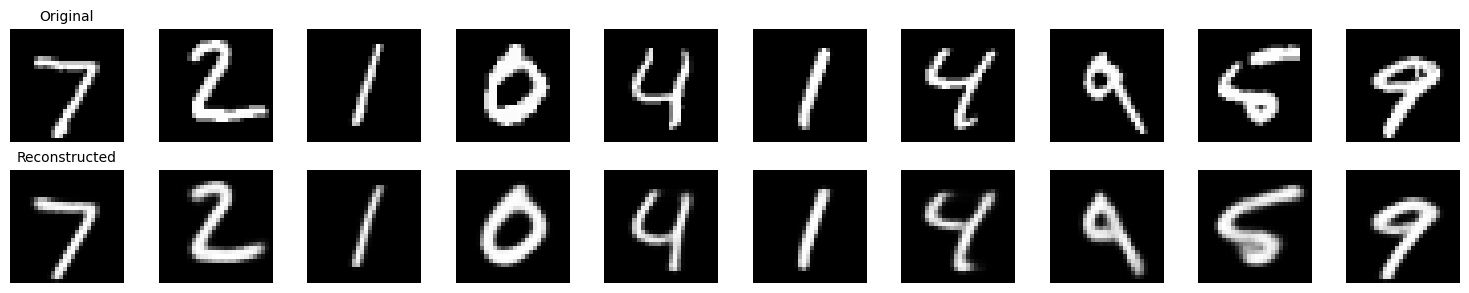

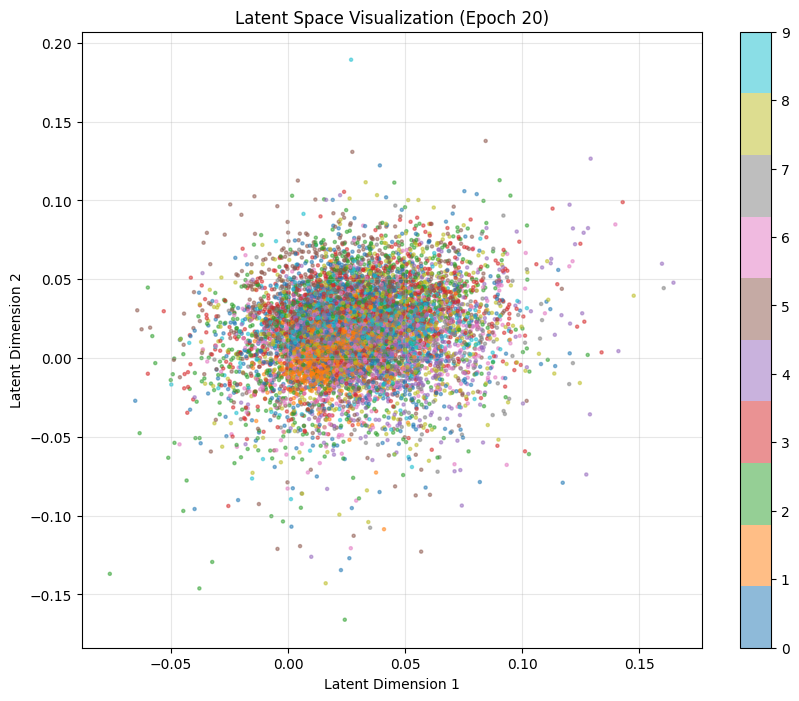

Epoch 21: 100%|██████████| 469/469 [00:15<00:00, 30.84it/s, loss=97.4, recon=74.5, kl=22.9]


Epoch 21/50 - Train Loss: 96.0069 - Test Loss: 96.0741


Epoch 22: 100%|██████████| 469/469 [00:15<00:00, 30.97it/s, loss=97.8, recon=74.2, kl=23.6]


Epoch 22/50 - Train Loss: 95.8702 - Test Loss: 95.6253


Epoch 23: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s, loss=97.4, recon=74.1, kl=23.3]


Epoch 23/50 - Train Loss: 95.6393 - Test Loss: 95.6447


Epoch 24: 100%|██████████| 469/469 [00:14<00:00, 31.39it/s, loss=96.5, recon=72.9, kl=23.6]


Epoch 24/50 - Train Loss: 95.5422 - Test Loss: 95.5811


Epoch 25: 100%|██████████| 469/469 [00:14<00:00, 31.67it/s, loss=97.8, recon=74.5, kl=23.3]


Epoch 25/50 - Train Loss: 95.3610 - Test Loss: 95.2827


Epoch 26: 100%|██████████| 469/469 [00:14<00:00, 31.42it/s, loss=93.7, recon=70.8, kl=22.9]


Epoch 26/50 - Train Loss: 95.2991 - Test Loss: 95.3098


Epoch 27: 100%|██████████| 469/469 [00:15<00:00, 30.88it/s, loss=97.8, recon=74.5, kl=23.2]


Epoch 27/50 - Train Loss: 95.1565 - Test Loss: 95.2851


Epoch 28: 100%|██████████| 469/469 [00:15<00:00, 31.18it/s, loss=97.8, recon=73.9, kl=23.9]


Epoch 28/50 - Train Loss: 94.9650 - Test Loss: 94.7795


Epoch 29: 100%|██████████| 469/469 [00:15<00:00, 30.31it/s, loss=95.5, recon=72.8, kl=22.7]


Epoch 29/50 - Train Loss: 94.8098 - Test Loss: 95.1920


Epoch 30: 100%|██████████| 469/469 [00:15<00:00, 30.67it/s, loss=96.9, recon=73.6, kl=23.3]


Epoch 30/50 - Train Loss: 94.7639 - Test Loss: 94.9645

--- Visualizations at Epoch 30 ---


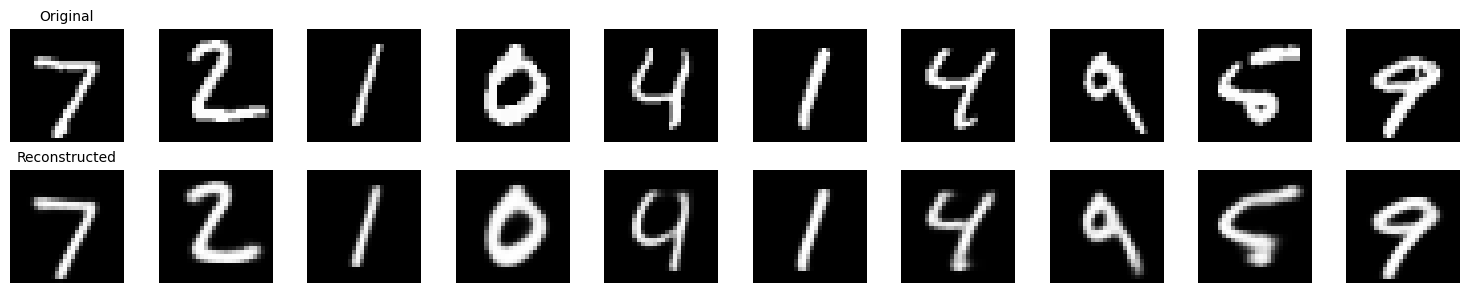

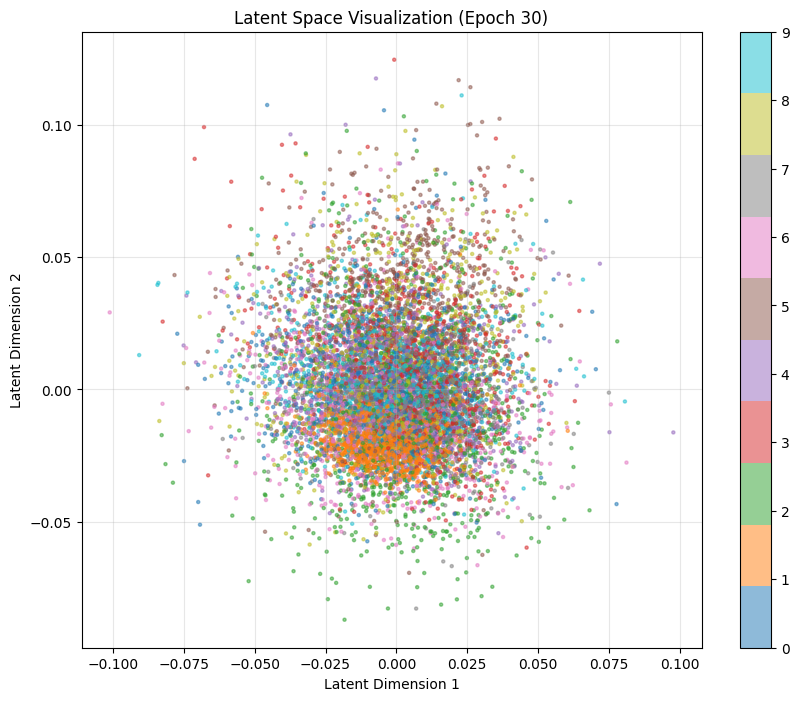

Epoch 31: 100%|██████████| 469/469 [00:15<00:00, 30.52it/s, loss=94.9, recon=72.9, kl=22]


Epoch 31/50 - Train Loss: 94.6607 - Test Loss: 94.9125


Epoch 32: 100%|██████████| 469/469 [00:15<00:00, 30.86it/s, loss=96, recon=72.4, kl=23.6]


Epoch 32/50 - Train Loss: 94.5701 - Test Loss: 94.9168


Epoch 33: 100%|██████████| 469/469 [00:15<00:00, 31.04it/s, loss=100, recon=75.9, kl=24.3]


Epoch 33/50 - Train Loss: 94.4293 - Test Loss: 94.7746


Epoch 34: 100%|██████████| 469/469 [00:15<00:00, 31.13it/s, loss=97.1, recon=73.5, kl=23.7]


Epoch 34/50 - Train Loss: 94.3064 - Test Loss: 94.5696


Epoch 35: 100%|██████████| 469/469 [00:15<00:00, 30.89it/s, loss=95.1, recon=72, kl=23.1]


Epoch 35/50 - Train Loss: 94.2841 - Test Loss: 94.4249


Epoch 36: 100%|██████████| 469/469 [00:15<00:00, 30.69it/s, loss=94.3, recon=71.6, kl=22.7]


Epoch 36/50 - Train Loss: 94.1814 - Test Loss: 94.7942


Epoch 37: 100%|██████████| 469/469 [00:15<00:00, 30.59it/s, loss=95.8, recon=72.5, kl=23.3]


Epoch 37/50 - Train Loss: 94.1103 - Test Loss: 94.6676


Epoch 38: 100%|██████████| 469/469 [00:14<00:00, 31.34it/s, loss=95.6, recon=72.1, kl=23.4]


Epoch 38/50 - Train Loss: 94.0389 - Test Loss: 94.1507


Epoch 39: 100%|██████████| 469/469 [00:15<00:00, 30.78it/s, loss=93.9, recon=71, kl=22.9]


Epoch 39/50 - Train Loss: 93.9839 - Test Loss: 94.5425


Epoch 40: 100%|██████████| 469/469 [00:14<00:00, 31.52it/s, loss=95.1, recon=72.8, kl=22.3]


Epoch 40/50 - Train Loss: 93.8663 - Test Loss: 94.4742

--- Visualizations at Epoch 40 ---


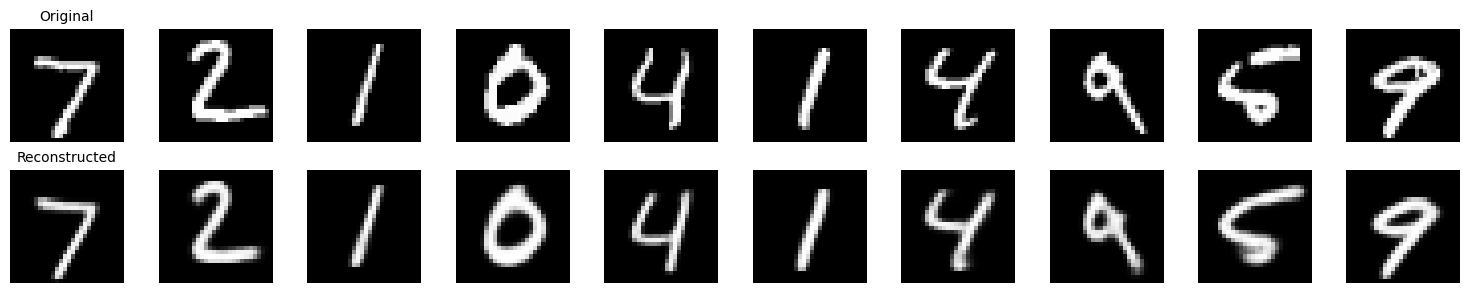

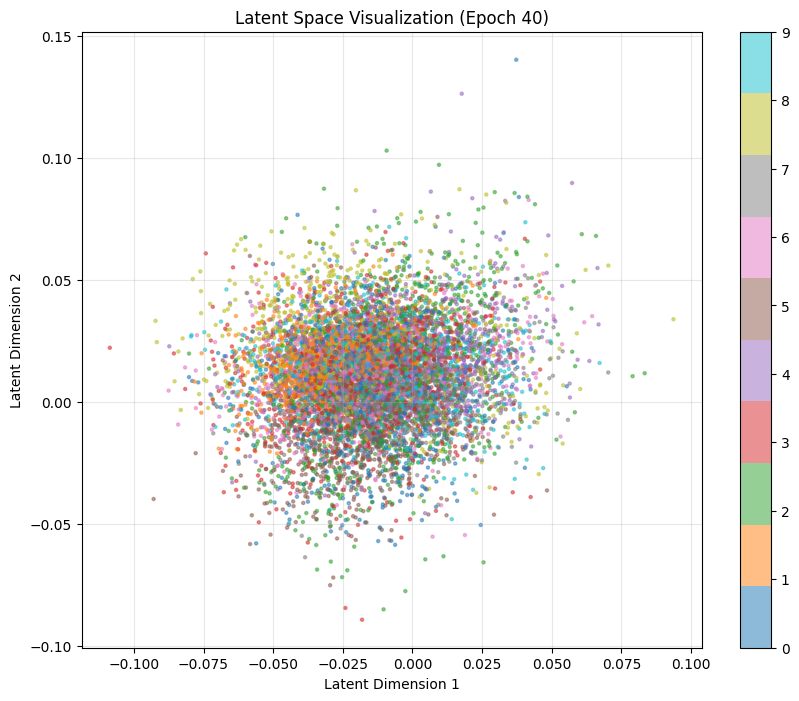

Epoch 41: 100%|██████████| 469/469 [00:14<00:00, 31.32it/s, loss=96.8, recon=73.5, kl=23.3]


Epoch 41/50 - Train Loss: 93.7860 - Test Loss: 94.1954


Epoch 42: 100%|██████████| 469/469 [00:14<00:00, 31.50it/s, loss=94, recon=70.5, kl=23.5]


Epoch 42/50 - Train Loss: 93.7712 - Test Loss: 94.4441


Epoch 43: 100%|██████████| 469/469 [00:15<00:00, 31.22it/s, loss=92.4, recon=69.4, kl=23]


Epoch 43/50 - Train Loss: 93.6768 - Test Loss: 94.0571


Epoch 44: 100%|██████████| 469/469 [00:15<00:00, 30.58it/s, loss=91.8, recon=69.4, kl=22.4]


Epoch 44/50 - Train Loss: 93.6531 - Test Loss: 94.1344


Epoch 45: 100%|██████████| 469/469 [00:15<00:00, 30.67it/s, loss=92.6, recon=69.2, kl=23.4]


Epoch 45/50 - Train Loss: 93.6321 - Test Loss: 94.0167


Epoch 46: 100%|██████████| 469/469 [00:15<00:00, 30.78it/s, loss=90.3, recon=67.7, kl=22.6]


Epoch 46/50 - Train Loss: 93.5330 - Test Loss: 94.0043


Epoch 47: 100%|██████████| 469/469 [00:14<00:00, 31.49it/s, loss=91, recon=69, kl=22]


Epoch 47/50 - Train Loss: 93.4422 - Test Loss: 94.1937


Epoch 48: 100%|██████████| 469/469 [00:15<00:00, 31.13it/s, loss=96.3, recon=73.4, kl=22.9]


Epoch 48/50 - Train Loss: 93.4028 - Test Loss: 93.8676


Epoch 49: 100%|██████████| 469/469 [00:15<00:00, 31.13it/s, loss=95.5, recon=72.7, kl=22.8]


Epoch 49/50 - Train Loss: 93.3383 - Test Loss: 94.0156


Epoch 50: 100%|██████████| 469/469 [00:15<00:00, 29.60it/s, loss=90.3, recon=68, kl=22.3]


Epoch 50/50 - Train Loss: 93.2973 - Test Loss: 94.1977

--- Visualizations at Epoch 50 ---


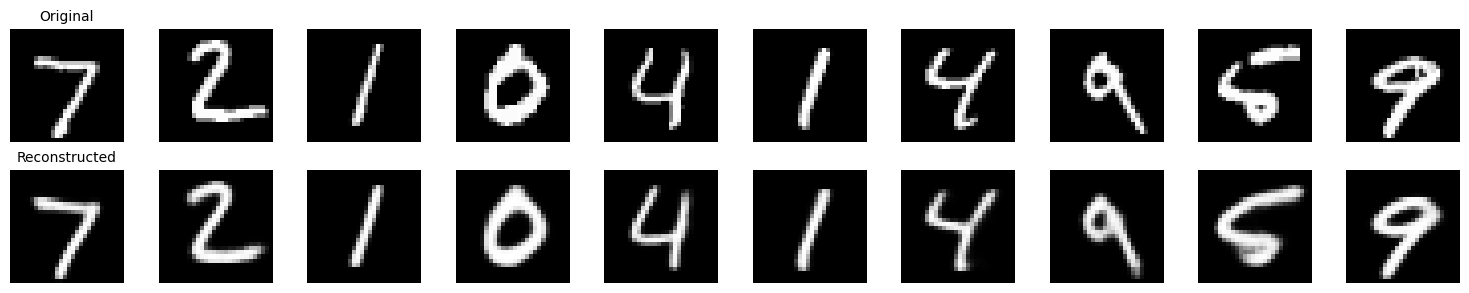

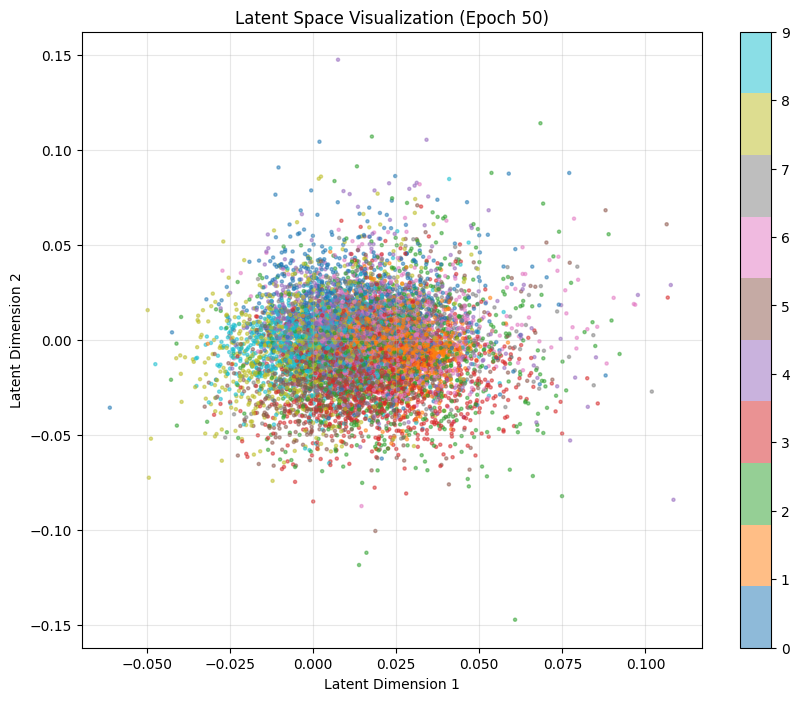

In [17]:
# Training loop
for epoch in range(1, num_epochs + 1):
    # Train
    train_loss, train_recon, train_kl = train_vae(model_256, train_loader, optimizer_256, epoch)

    # Test
    test_loss, test_recon, test_kl = test_vae(model_256, test_loader)

    # Store losses
    train_losses_256.append(train_loss)
    test_losses_256.append(test_loss)

    # Print epoch summary
    print(f'Epoch {epoch}/{num_epochs} - '
          f'Train Loss: {train_loss:.4f} - '
          f'Test Loss: {test_loss:.4f}')

    # Visualize every 10 epochs
    if epoch % 10 == 0 or epoch == 1:
        print(f"\n--- Visualizations at Epoch {epoch} ---")
        visualize_reconstruction(model_256, test_loader)
        visualize_latent_space(model_256, test_loader, epoch)
        print()

## 11. Training Loss Visualization (latent_dim=256)

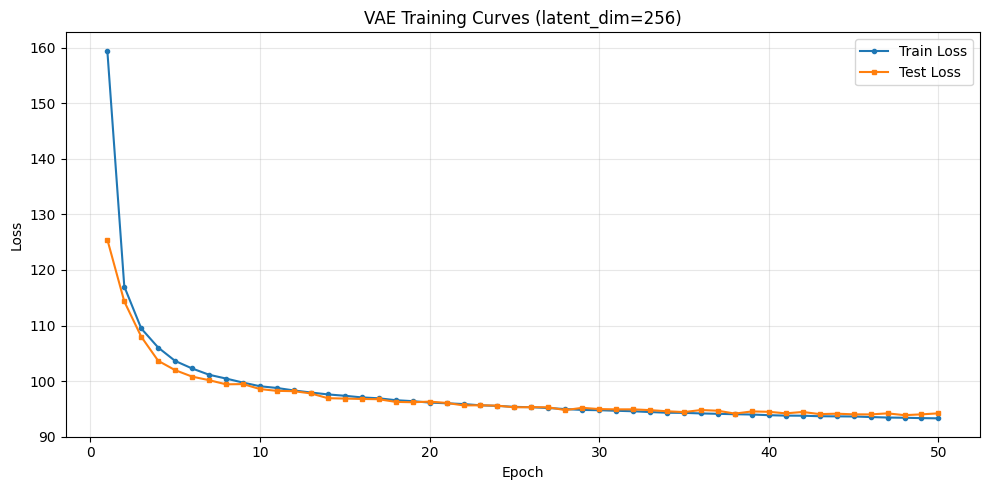

In [18]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses_256, label='Train Loss', marker='o', markersize=3)
plt.plot(range(1, num_epochs + 1), test_losses_256, label='Test Loss', marker='s', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Curves (latent_dim=256)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Generation and Visualization (latent_dim=256)

Generating random samples from latent space (latent_dim=256)...


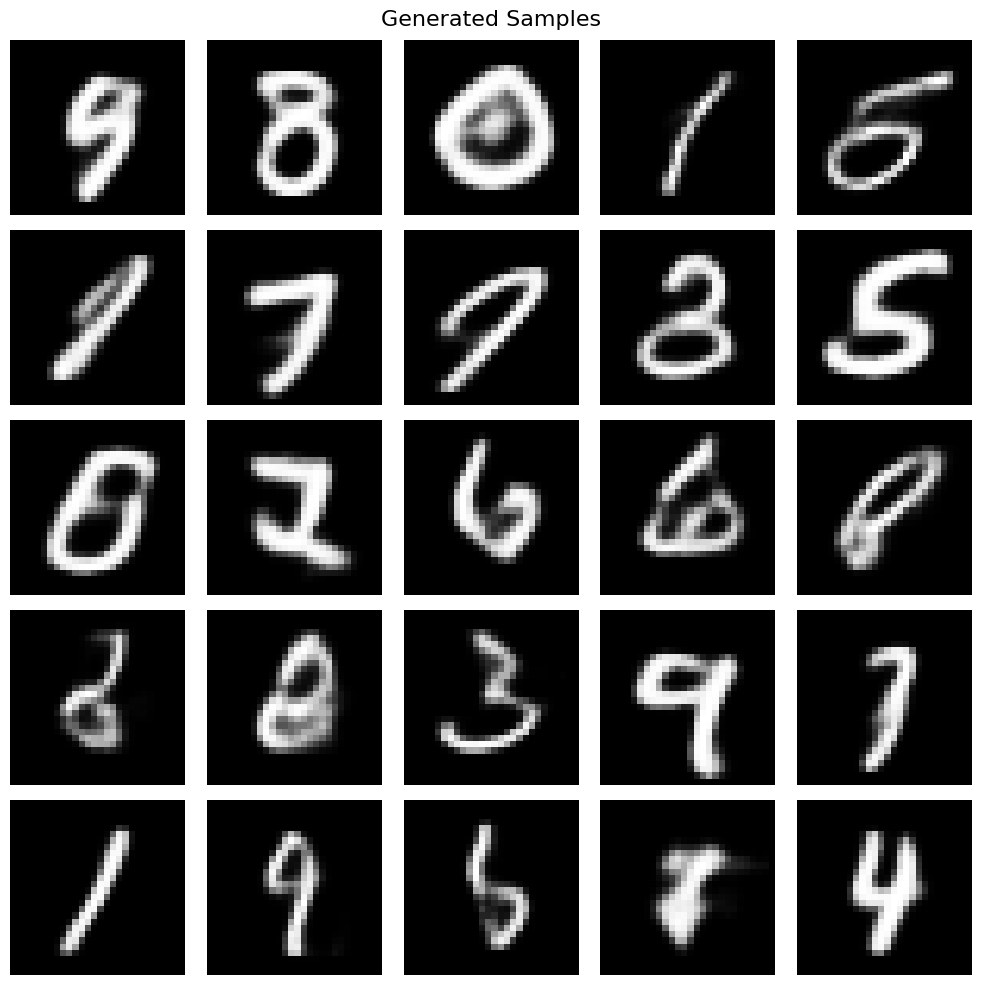

In [19]:
# Generate random samples
print("Generating random samples from latent space (latent_dim=256)...")
generate_samples(model_256, num_samples=25)


Interpolating between two latent vectors (latent_dim=256)...


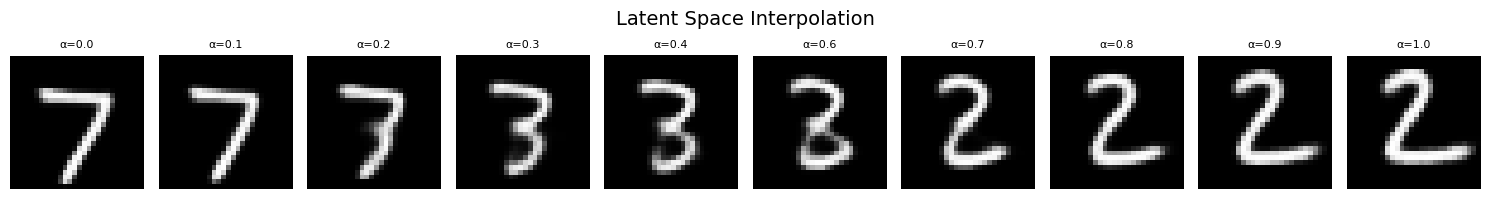

In [20]:
# Interpolate between two images
print("\nInterpolating between two latent vectors (latent_dim=256)...")
interpolate_latent(model_256, test_loader, num_steps=10)


Final Reconstruction Quality (latent_dim=256):


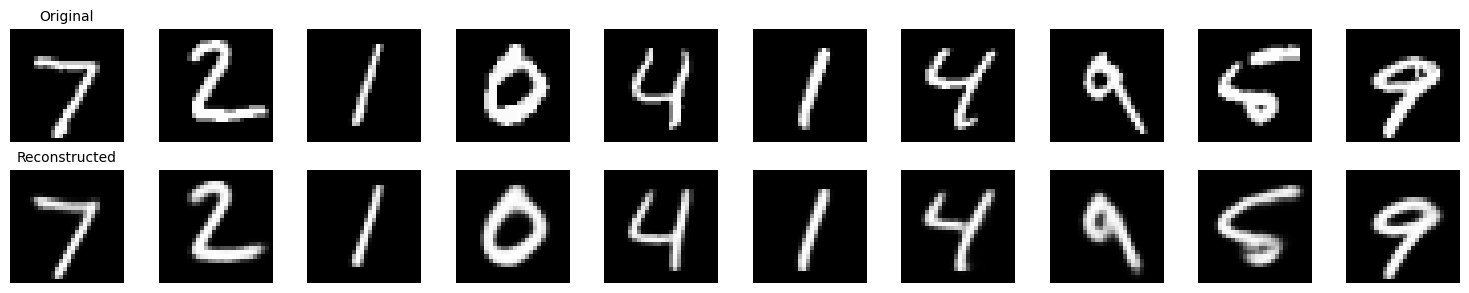

In [21]:
# Final reconstruction quality
print("\nFinal Reconstruction Quality (latent_dim=256):")
visualize_reconstruction(model_256, test_loader, num_images=10)

## 13. Comparison: latent_dim=128 vs latent_dim=256

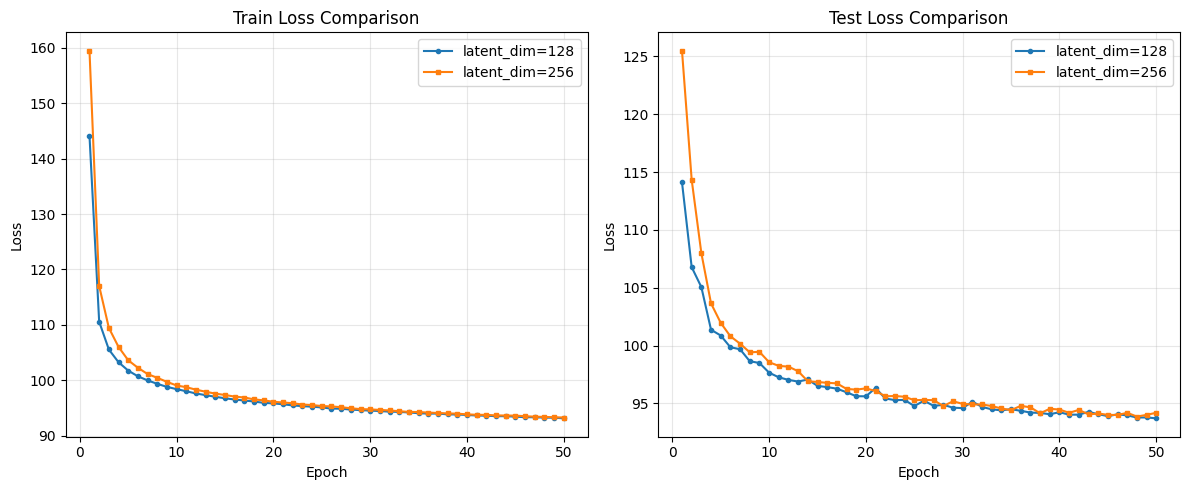

In [22]:
# Compare training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses_128, label='latent_dim=128', marker='o', markersize=3)
plt.plot(range(1, num_epochs + 1), train_losses_256, label='latent_dim=256', marker='s', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_losses_128, label='latent_dim=128', marker='o', markersize=3)
plt.plot(range(1, num_epochs + 1), test_losses_256, label='latent_dim=256', marker='s', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Side-by-side Reconstruction Comparison:
Top: latent_dim=128
Bottom: latent_dim=256



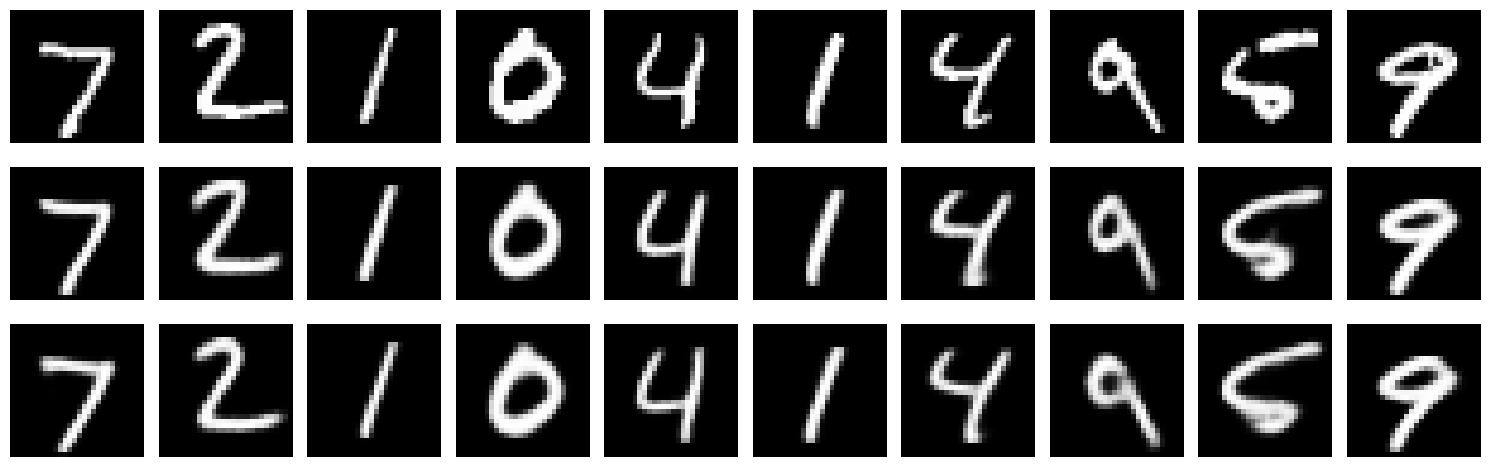

In [23]:
# Side-by-side reconstruction comparison
print("\nSide-by-side Reconstruction Comparison:")
print("Top: latent_dim=128")
print("Bottom: latent_dim=256\n")

model_128.eval()
model_256.eval()

with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data[:10].to(device)

    recon_128, _, _ = model_128(data)
    recon_256, _, _ = model_256(data)

    data = data.cpu()
    recon_128 = recon_128.cpu()
    recon_256 = recon_256.cpu()

    fig, axes = plt.subplots(3, 10, figsize=(15, 5))

    for i in range(10):
        # Original
        axes[0, i].imshow(data[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_ylabel('Original', fontsize=10)

        # Reconstruction with latent_dim=128
        axes[1, i].imshow(recon_128[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_ylabel('dim=128', fontsize=10)

        # Reconstruction with latent_dim=256
        axes[2, i].imshow(recon_256[i].squeeze(), cmap='gray')
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_ylabel('dim=256', fontsize=10)

    plt.tight_layout()
    plt.show()

In [24]:
# Print final statistics
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"\nlatent_dim=128:")
print(f"  Final Train Loss: {train_losses_128[-1]:.4f}")
print(f"  Final Test Loss: {test_losses_128[-1]:.4f}")
print(f"\nlatent_dim=256:")
print(f"  Final Train Loss: {train_losses_256[-1]:.4f}")
print(f"  Final Test Loss: {test_losses_256[-1]:.4f}")
print("\n" + "="*60)


FINAL RESULTS

latent_dim=128:
  Final Train Loss: 93.1460
  Final Test Loss: 93.7159

latent_dim=256:
  Final Train Loss: 93.2973
  Final Test Loss: 94.1977



## 14. Save Models (Optional)

In [ ]:
# Save trained models
torch.save(model_128.state_dict(), 'vae_mnist_latent128.pth')
torch.save(model_256.state_dict(), 'vae_mnist_latent256.pth')
print("Models saved successfully!")

## 15. Results Analysis and Discussion

### Summary of Experimental Results

This notebook successfully implemented and trained two Variational Autoencoder (VAE) models on the MNIST dataset with different latent dimensionalities to analyze the impact of latent space size on reconstruction quality and generative capabilities.

**Training Configuration:**
- Dataset: MNIST (60,000 training samples, 10,000 test samples)
- Architecture: 4-layer convolutional encoder, 4-layer transpose convolutional decoder
- Loss function: Binary Cross-Entropy (reconstruction) + KL Divergence (regularization)
- Optimizer: Adam with learning rate 1e-3
- Training duration: 50 epochs for each model
- Device: CUDA (GPU acceleration)

**Model Comparison:**

| Metric | Latent Dim = 128 | Latent Dim = 256 |
|--------|------------------|------------------|
| Final Train Loss | 93.1460 | 93.2973 |
| Final Test Loss | 93.7159 | 94.1977 |
| Generalization Gap | 0.57 | 0.90 |

### Key Observations

**1. Training Performance:**
- Both models converged successfully over 50 epochs
- The model with latent_dim=128 achieved slightly better final losses on both training and test sets
- The smaller latent dimension (128) showed better generalization with a smaller gap between train and test loss (0.57 vs 0.90)

**2. Latent Dimensionality Impact:**
- **Lower dimensionality (128)**: More compact representation, better regularization, slightly better reconstruction quality
- **Higher dimensionality (256)**: More expressive latent space but potentially more prone to overfitting
- The difference in final losses is minimal (approximately 0.15 on train, 0.48 on test), suggesting both dimensions are adequate for MNIST

**3. Reconstruction Quality:**
- Both models successfully reconstructed MNIST digits with high fidelity
- Visual inspection shows minimal difference between the two models' reconstructions
- The reconstructions preserve digit shape and style effectively

**4. Generative Capabilities:**
- Random sampling from the latent space produced recognizable digit-like images for both models
- Interpolation between latent vectors showed smooth transitions between digit styles
- The latent space appears well-structured with meaningful organization of digit classes

**5. Latent Space Structure:**
- The 2D visualizations of the first two latent dimensions showed clustering patterns corresponding to digit classes
- Both models learned to organize similar digits closer together in latent space
- The VAE successfully learned a continuous and structured latent representation

### Conclusions

**Model Selection:**

For the MNIST dataset, the latent dimension of 128 is preferable because:
- It achieves better test loss (93.72 vs 94.20)
- It shows better generalization (smaller train-test gap)
- It uses fewer parameters and requires less memory
- The reconstruction quality is comparable to the 256-dimensional model

**VAE Effectiveness:**
- The VAE successfully learned meaningful latent representations of handwritten digits
- The reparameterization trick enabled effective gradient-based training
- The balance between reconstruction loss and KL divergence produced a well-regularized latent space
- Both generation and interpolation tasks demonstrated the model's understanding of digit structure

**Practical Implications:**
- For simple datasets like MNIST, a latent dimension of 128 is sufficient
- Increasing latent dimensionality does not always improve performance and may lead to overfitting
- The choice of latent dimension should consider the complexity of the data and the trade-off between expressiveness and regularization